# Imports

In [18]:
import os
import logging
import importlib
importlib.reload(logging)
log = logging.getLogger()
log.setLevel('INFO')
import sys

logging.basicConfig(format='%(asctime)s %(levelname)s |: %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import mne
from mne.io import concatenate_raws
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing
import numpy as np
from torchsummary import summary
import torch

from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
from braindecode.models.deep4 import Deep4Net
import pickle

In [19]:
import os
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers import LSTM, Conv2D,Conv2DTranspose
from keras.layers import Activation, Conv3D, Conv3DTranspose
from keras.layers import Dropout, MaxPooling2D, MaxPooling3D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.utils import plot_model
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy.signal as ss
from sklearn import preprocessing
import keras
from sklearn.model_selection import train_test_split
from keras.layers import ConvLSTM2D, BatchNormalization, SpatialDropout3D
from keras.utils import to_categorical

# hide_toggle()

# Data processing

In [3]:
path = './processed_data/'
data_type = 'XDAWN'
X_pseudo_test = np.load(path+f'X_pseudo_test_{data_type}.npy', )
X_word_test = np.load(path + f'X_word_test_{data_type}.npy', )
X_pseudo_train = np.load(path + f'X_pseudo_train_{data_type}.npy', )
X_word_train = np.load(path + f'X_word_train_{data_type}.npy', )

In [4]:
X_test = np.concatenate((X_word_test,X_pseudo_test))
X_test = (X_test * 1e8).astype(np.float32)
y_test = np.zeros(X_test.shape[0])
y_test[:X_word_test.shape[0]] = 1
ind = np.arange(X_test.shape[0])
np.random.shuffle(ind)
X_test = X_test[ind,:,:]
y_test = y_test[ind]

X_train = np.concatenate((X_word_train,X_pseudo_train))
X_train = (X_train * 1e8).astype(np.float32)
y_train = np.zeros(X_train.shape[0])
y_train[:X_word_train.shape[0]] = 1
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)

In [5]:
print(f'X_train; {X_train.shape}')
print(f'X_test; {X_test.shape}')
print(f'y_test; {y_test.shape}')
print(f'y_train; {y_train.shape}')

X_train; (12000, 19, 306)
X_test; (6063, 19, 306)
y_test; (6063,)
y_train; (12000,)


In [6]:
for i in range(X_train.shape[0]):
    for ch in range(19):
        X_train[i,ch,:] = (X_train[i,ch,:] - np.mean(X_train[i,ch,:]))/np.std(X_train[i,ch,:])
for i in range(X_test.shape[0]):
    for ch in range(19):
        X_test[i,ch,:] = (X_test[i,ch,:] - np.mean(X_test[i,ch,:]))/np.std(X_test[i,ch,:])

In [7]:
X10_20 = np.zeros((X_train.shape[0],1,5,5,X_train.shape[2]))
X10_20[:,0,0,1,:] = X_train[:,0,:]
X10_20[:,0,0,3,:] = X_train[:,1,:]
X10_20[:,0,1,:,:] = X_train[:,2:7,:]
X10_20[:,0,2,:,:] = X_train[:,7:12,:]
X10_20[:,0,3,:,:] = X_train[:,12:17,:]
X10_20[:,0,4,1,:] = X_train[:,17,:]
X10_20[:,0,4,3,:] = X_train[:,18,:]
X_train = X10_20

In [8]:
X10_20 = np.zeros((X_test.shape[0],1,5,5,X_test.shape[2]))
X10_20[:,0,0,1,:] = X_test[:,0,:]
X10_20[:,0,0,3,:] = X_test[:,1,:]
X10_20[:,0,1,:,:] = X_test[:,2:7,:]
X10_20[:,0,2,:,:] = X_test[:,7:12,:]
X10_20[:,0,3,:,:] = X_test[:,12:17,:]
X10_20[:,0,4,1,:] = X_test[:,17,:]
X10_20[:,0,4,3,:] = X_test[:,18,:]
X_test = X10_20

In [9]:
X_train=np.einsum('ijklm->imjkl',X_train)
X_test=np.einsum('ijklm->imjkl',X_test)


In [10]:
print(f'X_train; {X_train.shape}')
print(f'X_test; {X_test.shape}')
print(f'y_test; {y_test.shape}')
print(f'y_train; {y_train.shape}')

X_train; (12000, 306, 1, 5, 5)
X_test; (6063, 306, 1, 5, 5)
y_test; (6063,)
y_train; (12000,)


In [11]:
y_test = to_categorical(y_test).astype(np.integer)
y_train = to_categorical(y_train).astype(np.integer)


y_test; (6063, 2)
y_train; (12000, 2)


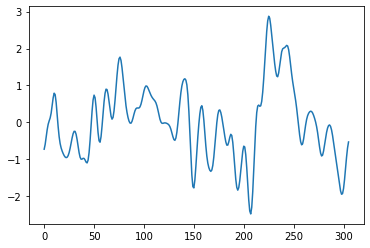

In [12]:
plt.plot(X_train[0,:,0,2,2])
print(f'y_test; {y_test.shape}')
print(f'y_train; {y_train.shape}')

In [13]:
ind_test = np.random.shuffle(np.arange(X_test.shape[0]))
ind_train = np.random.shuffle(np.arange(X_train.shape[0]))

X_train = X_train[ind_train]
y_train = y_train[ind_train]

X_test = X_test[ind_test]
y_test = y_test[ind_test]pip install tensorflow-gpu==1.15

In [14]:
X_train = X_train[0]
y_train = y_train[0]
X_test = X_test[0]
y_test = y_test[0]

In [15]:
# del model

# Model configuration
batch_size = 100
no_epochs = 30
learning_rate = 0.001
no_classes = 2
validation_spl = 0.2
verbosity = 1
sample_shape = X_train.shape[1:]


"""LSTMconv2D"""
model = Sequential()
model.add(ConvLSTM2D(filters = 15, kernel_size = (1,1), activation='tanh', dropout = 0.4, return_sequences = True, input_shape = sample_shape,data_format='channels_first'))
model.add(BatchNormalization())
# model.add(SpatialDropout3D(1))
# model.add(Dense(10, activation='tanh'))
# model.add(ConvLSTM2D(filters = 3, kernel_size = (1,1), activation='tanh', dropout = 0.5, return_sequences = True))
# model.add(BatchNormalization())
model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_spl)

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Binary crossentropy & Accuracy
plt.plot(history.history['loss'], label='Binary crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Binary crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

hide_toggle()

2020-04-25 13:33:48,520 WARNING |: From /home/ukulele_personal/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-04-25 13:33:49,007 WARNING |: From /home/ukulele_personal/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-04-25 13:33:50,031 WARNING |: From /home/ukulele_personal/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

Train on 9600 samples, validate

KeyboardInterrupt: 

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16179368476067962700
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 714354651420220715
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10809142102633208841
physical_device_desc: "device: XLA_GPU device"
]


In [20]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [ ]:
train_set = SignalAndTarget(X_train, y=y_train)
valid_set = SignalAndTarget(X_test, y=y_test)

# ShallowFBCSPNet model

In [ ]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2],
                        final_conv_length='auto')
if cuda:
    model.cuda()
    

optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
# optimizer = AdamW(model.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1,)

In [ ]:
model.fit(train_set.X, train_set.y, epochs=10, batch_size=64, scheduler='cosine',
         validation_data=(valid_set.X, valid_set.y),)

In [ ]:
model_path = './models/'
torch.save(model.network, model_path + f'ShallowFBCSPNet_{data_type}')

In [ ]:
model_path = './models/'
pickle_out = open(model_path + f'ShallowFBCSPNet_{data_type}.pickle',"wb")
pickle.dump(model, pickle_out)

# Deep4Net model

In [ ]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 306
# final_conv_length determines the size of the receptive field of the ConvNet
model = Deep4Net(in_chans=19, n_classes=2, input_time_length=input_time_length,
                 filter_length_3=5, filter_length_4=5,
                 pool_time_stride=2,
                 stride_before_pool=True,
                        final_conv_length=1)
if cuda:
    model.cuda()
    
optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
model.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

In [ ]:
input_time_length = 306
model.fit(train_set.X, train_set.y, epochs=10, batch_size=64, scheduler='cosine',
          input_time_length=input_time_length,
         validation_data=(valid_set.X, valid_set.y),)